# PyTorch Custom Dataset Notebook

## 0. Importing PyTorch and Setting Up Device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Mon Jan  6 10:36:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a writable data folder
data_path = Path('/kaggle/working/')
image_path = data_path / 'pizza-steak-sushi'

if image_path.is_dir():
    print(f'{image_path} directory already exists ...')
else:
    print(f'{image_path} does not exist, creating one ...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, and sushi data
    zip_file_path = data_path / 'pizza_steak_sushi.zip'
    with open(zip_file_path, 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
        f.write(request.content)
    
    # Unzip pizza, steak, and sushi data
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(image_path)
    
    print(f"Data downloaded and extracted to {image_path}.")

/kaggle/working/pizza-steak-sushi does not exist, creating one ...
Data downloaded and extracted to /kaggle/working/pizza-steak-sushi.


## 2. Data Preparation and Exploration

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in /kaggle/working/pizza-steak-sushi
There are 3 directories and 0 images in /kaggle/working/pizza-steak-sushi/test
There are 0 directories and 25 images in /kaggle/working/pizza-steak-sushi/test/pizza
There are 0 directories and 31 images in /kaggle/working/pizza-steak-sushi/test/sushi
There are 0 directories and 19 images in /kaggle/working/pizza-steak-sushi/test/steak
There are 3 directories and 0 images in /kaggle/working/pizza-steak-sushi/train
There are 0 directories and 78 images in /kaggle/working/pizza-steak-sushi/train/pizza
There are 0 directories and 72 images in /kaggle/working/pizza-steak-sushi/train/sushi
There are 0 directories and 75 images in /kaggle/working/pizza-steak-sushi/train/steak


In [7]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/kaggle/working/pizza-steak-sushi/train'),
 PosixPath('/kaggle/working/pizza-steak-sushi/test'))

### 2.1 Visualising and image

Random image path: /kaggle/working/pizza-steak-sushi/test/steak/296375.jpg
Image class: steak
Image height: 512
Image width: 382


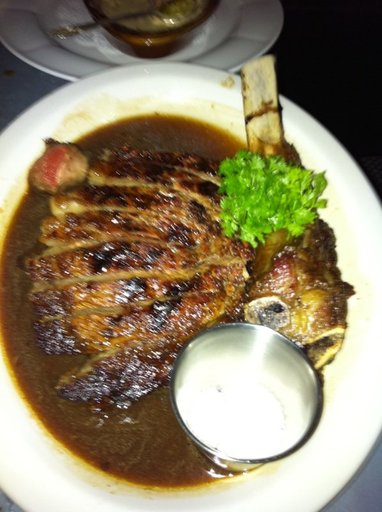

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

img

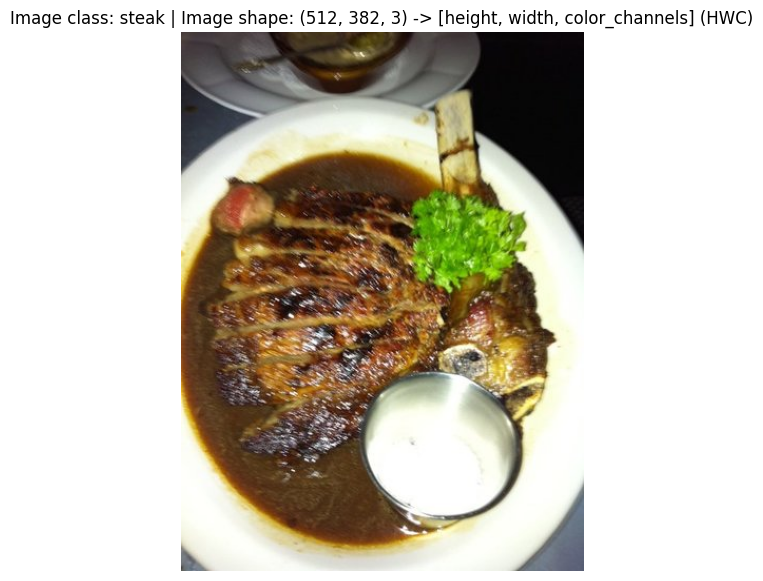

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)')
plt.axis(False);

In [10]:
img_as_array

array([[[ 70,  58,  58],
        [ 70,  58,  58],
        [ 70,  58,  58],
        ...,
        [ 11,   6,  10],
        [ 10,   5,   9],
        [ 11,   6,  10]],

       [[ 72,  60,  60],
        [ 72,  60,  60],
        [ 73,  61,  61],
        ...,
        [ 11,   6,  10],
        [ 11,   6,  10],
        [ 11,   6,  10]],

       [[ 73,  62,  60],
        [ 74,  63,  61],
        [ 75,  64,  62],
        ...,
        [ 11,   6,  10],
        [ 11,   6,  10],
        [ 11,   6,  10]],

       ...,

       [[ 72,  72,  70],
        [ 85,  87,  84],
        [101, 103, 102],
        ...,
        [ 88,  94, 116],
        [ 86,  94, 115],
        [ 85,  93, 114]],

       [[ 84,  85,  80],
        [ 93,  95,  92],
        [102, 104, 103],
        ...,
        [ 89,  95, 117],
        [ 87,  95, 116],
        [ 85,  93, 114]],

       [[ 94,  95,  90],
        [ 98, 100,  95],
        [101, 103, 102],
        ...,
        [ 91,  97, 119],
        [ 89,  97, 118],
        [ 87,  95, 116]]

## 3. Transforming data

Before we can use our image data with PyTorch
1. Turn the target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.tranforms`

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.2627, 0.2784, 0.2941],
         [0.0392, 0.0392, 0.0392,  ..., 0.2549, 0.2627, 0.2824],
         [0.0314, 0.0314, 0.0275,  ..., 0.2745, 0.2706, 0.2745],
         ...,
         [0.3765, 0.3882, 0.3961,  ..., 0.9294, 0.8196, 0.6275],
         [0.3608, 0.3725, 0.3843,  ..., 0.7412, 0.5176, 0.4627],
         [0.3529, 0.3647, 0.3725,  ..., 0.5059, 0.4353, 0.4157]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.2275, 0.2392, 0.2549],
         [0.0235, 0.0235, 0.0235,  ..., 0.2196, 0.2235, 0.2431],
         [0.0196, 0.0235, 0.0196,  ..., 0.2392, 0.2392, 0.2392],
         ...,
         [0.4000, 0.4118, 0.4196,  ..., 0.9255, 0.8157, 0.6275],
         [0.3882, 0.3961, 0.4039,  ..., 0.7333, 0.5176, 0.4745],
         [0.3804, 0.3882, 0.3922,  ..., 0.5255, 0.4667, 0.4353]],

        [[0.0392, 0.0392, 0.0392,  ..., 0.2431, 0.2431, 0.2431],
         [0.0392, 0.0353, 0.0353,  ..., 0.2392, 0.2353, 0.2431],
         [0.0314, 0.0353, 0.0314,  ..., 0.2549, 0.2471, 0.

In [14]:
# 20:47:42